# March Machine Learning Mania

Every year a Kaggle competition is held where contests attempt to predict the outcome of the March Madness NCAA Basketball tournament. Our group is using experimenting with the differernt types of models and data features to produce the most accurate predictions possible.

## Importing Libraries

In [139]:
import re
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import *
from sklearn.linear_model import *
from sklearn.model_selection import *
from sklearn.naive_bayes import GaussianNB

## Data Preparation

### Seeds

In [140]:
df_seeds = pd.concat([
    pd.read_csv("march-machine-learning-mania-2023/MNCAATourneySeeds.csv"),
    pd.read_csv("march-machine-learning-mania-2023/WNCAATourneySeeds.csv")
],    ignore_index=True)
df_seeds.head()

,Season,Seed,TeamID
0,1985,W01,1207
1,1985,W02,1210
2,1985,W03,1228
3,1985,W04,1260
4,1985,W05,1374


### Regular season results

Detailed results from the regular season are used to predict the outcome of the tournament

In [141]:
df_detailed_season = pd.concat([
    pd.read_csv("march-machine-learning-mania-2023/MRegularSeasonDetailedResults.csv"),
    pd.read_csv("march-machine-learning-mania-2023/WRegularSeasonDetailedResults.csv")
], ignore_index=True)

df_detailed_season.drop(['NumOT', 'WLoc'], axis=1, inplace=True)

In [142]:
df_detailed_season['WTR'] = df_detailed_season['WOR'] + df_detailed_season['WDR']
df_detailed_season['LTR'] = df_detailed_season['LOR'] + df_detailed_season['LDR']
df_detailed_season['TR'] = df_detailed_season['WTR'] + df_detailed_season['LTR']
df_detailed_season['ScoreGap'] = df_detailed_season['WScore'] - df_detailed_season['LScore']

df_detailed_season.drop(['WStl', 'WBlk', 'WPF', 'LStl', 'LBlk', 'LPF'], axis=1, inplace=True)

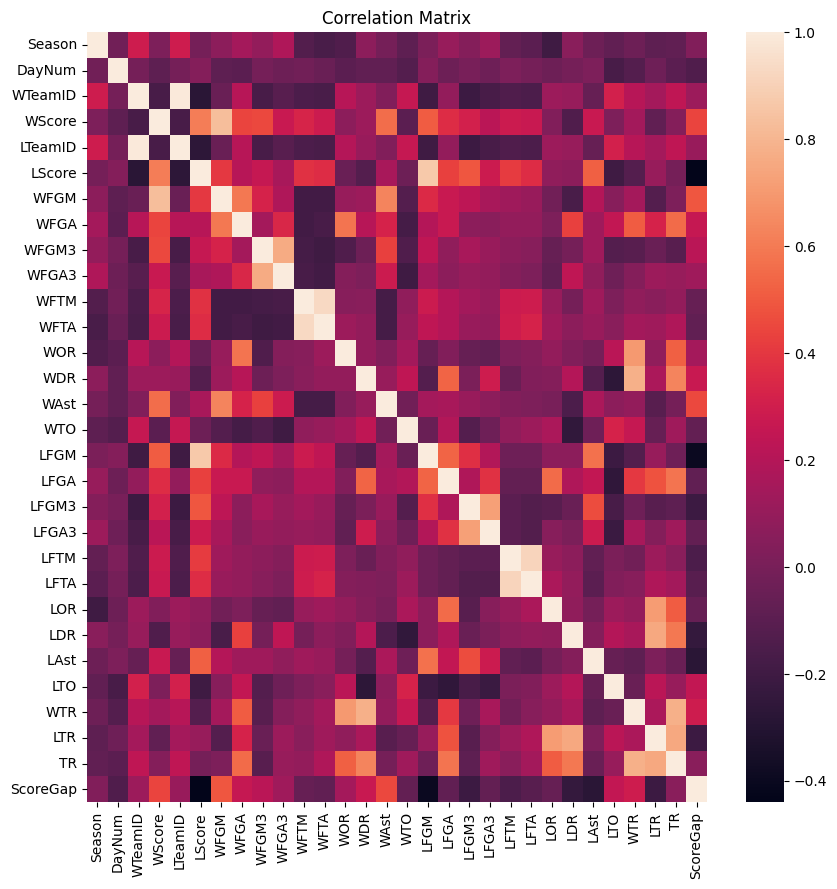

In [143]:
corrs = round(df_detailed_season.corr(), 2)

plt.figure(figsize=(10,10))
sns.heatmap(corrs)
plt.title('Correlation Matrix')
plt.show()

### Features
Aggregate the results for the fields we will later use for our features.

For each team at each season, computing:
- Number of wins
- Number of losses
- Average score gap of wins
- Average score gap of losses
- Total field goals made and attempted for wins and losses
- Total 3-point field goals made and attempted for wins and losses
- Total free throws made and attempted for wins and losses
- Total rebounds by the team for wins and losses
- Total rebounds in the game for wins and losses
- Total assists for wins and losses
- Total turnovers for wins and losses

And use the following features ([explained here](https://en.wikipedia.org/wiki/Basketball_statistics)):

- Win Ratio
- Average score gap
- Field goal %
- 3-point field goal %
- Free throw %
- [Effective field goal %](https://en.wikipedia.org/wiki/Effective_field_goal_percentage)
- [True shooting %](https://en.wikipedia.org/wiki/True_shooting_percentage)
- Total rebound %
- Assist to turnover ratio
- Turnover %
- Offensive rating (Points scored per possession)
- Defensive rating (Points allowed per opposition possession)
- [Net rating (Offensive rating - Defensive rating)](https://www.pivotanalysis.com/post/net-rating)


In [144]:
num_win = df_detailed_season.groupby(['Season', 'WTeamID']).count().reset_index()[['Season', 'WTeamID', 'DayNum']].rename(columns={"DayNum": "NumWins", "WTeamID": "TeamID"})
num_loss = df_detailed_season.groupby(['Season', 'LTeamID']).count().reset_index()[['Season', 'LTeamID', 'DayNum']].rename(columns={"DayNum": "NumLosses", "LTeamID": "TeamID"})
gap_win = df_detailed_season.groupby(['Season', 'WTeamID']).mean().reset_index()[['Season', 'WTeamID', 'ScoreGap']].rename(columns={"ScoreGap": "GapWins", "WTeamID": "TeamID"})
gap_loss = df_detailed_season.groupby(['Season', 'LTeamID']).mean().reset_index()[['Season', 'LTeamID', 'ScoreGap']].rename(columns={"ScoreGap": "GapLosses", "LTeamID": "TeamID"})
fgm_win = df_detailed_season.groupby(['Season', 'WTeamID']).sum().reset_index()[['Season', 'WTeamID', 'WFGM']].rename(columns={"WFGM": "FGMWins", "WTeamID": "TeamID"})
fgm_loss = df_detailed_season.groupby(['Season', 'LTeamID']).sum().reset_index()[['Season', 'LTeamID', 'LFGM']].rename(columns={"LFGM": "FGMLosses", "LTeamID": "TeamID"})
fga_win = df_detailed_season.groupby(['Season', 'WTeamID']).sum().reset_index()[['Season', 'WTeamID', 'WFGA']].rename(columns={"WFGA": "FGAWins", "WTeamID": "TeamID"})
fga_loss = df_detailed_season.groupby(['Season', 'LTeamID']).sum().reset_index()[['Season', 'LTeamID', 'LFGA']].rename(columns={"LFGA": "FGALosses", "LTeamID": "TeamID"})
fgm3_win = df_detailed_season.groupby(['Season', 'WTeamID']).sum().reset_index()[['Season', 'WTeamID', 'WFGM3']].rename(columns={"WFGM3": "FGM3Wins", "WTeamID": "TeamID"})
fgm3_loss = df_detailed_season.groupby(['Season', 'LTeamID']).sum().reset_index()[['Season', 'LTeamID', 'LFGM3']].rename(columns={"LFGM3": "FGM3Losses", "LTeamID": "TeamID"})
fga3_win = df_detailed_season.groupby(['Season', 'WTeamID']).sum().reset_index()[['Season', 'WTeamID', 'WFGA3']].rename(columns={"WFGA3": "FGA3Wins", "WTeamID": "TeamID"})
fga3_loss = df_detailed_season.groupby(['Season', 'LTeamID']).sum().reset_index()[['Season', 'LTeamID', 'LFGA3']].rename(columns={"LFGA3": "FGA3Losses", "LTeamID": "TeamID"})
ftm_win = df_detailed_season.groupby(['Season', 'WTeamID']).sum().reset_index()[['Season', 'WTeamID', 'WFTM']].rename(columns={"WFTM": "FTMWins", "WTeamID": "TeamID"})
ftm_loss = df_detailed_season.groupby(['Season', 'LTeamID']).sum().reset_index()[['Season', 'LTeamID', 'LFTM']].rename(columns={"LFTM": "FTMLosses", "LTeamID": "TeamID"})
fta_win = df_detailed_season.groupby(['Season', 'WTeamID']).sum().reset_index()[['Season', 'WTeamID', 'WFTA']].rename(columns={"WFTA": "FTAWins", "WTeamID": "TeamID"})
fta_loss = df_detailed_season.groupby(['Season', 'LTeamID']).sum().reset_index()[['Season', 'LTeamID', 'LFTA']].rename(columns={"LFTA": "FTALosses", "LTeamID": "TeamID"})
teamreb_win = df_detailed_season.groupby(['Season', 'WTeamID']).sum().reset_index()[['Season', 'WTeamID', 'WTR']].rename(columns={"WTR": "TeamRebWins", "WTeamID": "TeamID"})
teamreb_loss = df_detailed_season.groupby(['Season', 'LTeamID']).sum().reset_index()[['Season', 'LTeamID', 'LTR']].rename(columns={"LTR": "TeamRebLosses", "LTeamID": "TeamID"})
gamereb_win = df_detailed_season.groupby(['Season', 'WTeamID']).sum().reset_index()[['Season', 'WTeamID', 'TR']].rename(columns={"TR": "GameRebWins", "WTeamID": "TeamID"})
gamereb_loss = df_detailed_season.groupby(['Season', 'LTeamID']).sum().reset_index()[['Season', 'LTeamID', 'TR']].rename(columns={"TR": "GameRebLosses", "LTeamID": "TeamID"})
ast_win = df_detailed_season.groupby(['Season', 'WTeamID']).sum().reset_index()[['Season', 'WTeamID', 'WAst']].rename(columns={"WAst": "AstWins", "WTeamID": "TeamID"})
ast_loss = df_detailed_season.groupby(['Season', 'LTeamID']).sum().reset_index()[['Season', 'LTeamID', 'LAst']].rename(columns={"LAst": "AstLosses", "LTeamID": "TeamID"})
to_win = df_detailed_season.groupby(['Season', 'WTeamID']).sum().reset_index()[['Season', 'WTeamID', 'WTO']].rename(columns={"WTO": "TOWins", "WTeamID": "TeamID"})
to_loss = df_detailed_season.groupby(['Season', 'LTeamID']).sum().reset_index()[['Season', 'LTeamID', 'LTO']].rename(columns={"LTO": "TOLosses", "LTeamID": "TeamID"})
opp_pts_win = df_detailed_season.groupby(['Season', 'WTeamID']).sum().reset_index()[['Season', 'WTeamID', 'LScore']].rename(columns={"LScore": "oppPTSWins", "WTeamID": "TeamID"})
opp_pts_loss = df_detailed_season.groupby(['Season', 'LTeamID']).sum().reset_index()[['Season', 'LTeamID', 'WScore']].rename(columns={"WScore": "oppPTSLosses", "LTeamID": "TeamID"})
opp_fga_win = df_detailed_season.groupby(['Season', 'WTeamID']).sum().reset_index()[['Season', 'WTeamID', 'LFGA']].rename(columns={"LFGA": "oppFGAWins", "WTeamID": "TeamID"})
opp_fga_loss = df_detailed_season.groupby(['Season', 'LTeamID']).sum().reset_index()[['Season', 'LTeamID', 'WFGA']].rename(columns={"WFGA": "oppFGALosses", "LTeamID": "TeamID"})
opp_fta_win = df_detailed_season.groupby(['Season', 'WTeamID']).sum().reset_index()[['Season', 'WTeamID', 'LFTA']].rename(columns={"LFTA": "oppFTAWins", "WTeamID": "TeamID"})
opp_fta_loss = df_detailed_season.groupby(['Season', 'LTeamID']).sum().reset_index()[['Season', 'LTeamID', 'WFTA']].rename(columns={"WFTA": "oppFTALosses", "LTeamID": "TeamID"})
opp_to_win = df_detailed_season.groupby(['Season', 'WTeamID']).sum().reset_index()[['Season', 'WTeamID', 'LTO']].rename(columns={"LTO": "oppTOWins", "WTeamID": "TeamID"})
opp_to_loss = df_detailed_season.groupby(['Season', 'LTeamID']).sum().reset_index()[['Season', 'LTeamID', 'WTO']].rename(columns={"WTO": "oppTOLosses", "LTeamID": "TeamID"})


In [145]:
df_features_season_w = df_detailed_season.groupby(['Season', 'WTeamID']).count().reset_index()[['Season', 'WTeamID']].rename(columns={"WTeamID": "TeamID"})
df_features_season_l = df_detailed_season.groupby(['Season', 'LTeamID']).count().reset_index()[['Season', 'LTeamID']].rename(columns={"LTeamID": "TeamID"})
df_features_season = pd.concat([
    df_features_season_w, 
    df_features_season_l
], axis=0).drop_duplicates().sort_values(['Season', 'TeamID']).reset_index(drop=True)

#### Merge, compute aggregates

In [146]:
df_features_season = df_features_season.merge(num_win, on=['Season', 'TeamID'], how='left')
df_features_season = df_features_season.merge(num_loss, on=['Season', 'TeamID'], how='left')
df_features_season = df_features_season.merge(gap_win, on=['Season', 'TeamID'], how='left')
df_features_season = df_features_season.merge(gap_loss, on=['Season', 'TeamID'], how='left')
df_features_season = df_features_season.merge(fgm_win, on=['Season', 'TeamID'], how='left')
df_features_season = df_features_season.merge(fgm_loss, on=['Season', 'TeamID'], how='left')
df_features_season = df_features_season.merge(fga_win, on=['Season', 'TeamID'], how='left')
df_features_season = df_features_season.merge(fga_loss, on=['Season', 'TeamID'], how='left')
df_features_season = df_features_season.merge(fgm3_win, on=['Season', 'TeamID'], how='left')
df_features_season = df_features_season.merge(fgm3_loss, on=['Season', 'TeamID'], how='left')
df_features_season = df_features_season.merge(fga3_win, on=['Season', 'TeamID'], how='left')
df_features_season = df_features_season.merge(fga3_loss, on=['Season', 'TeamID'], how='left')
df_features_season = df_features_season.merge(ftm_win, on=['Season', 'TeamID'], how='left')
df_features_season = df_features_season.merge(ftm_loss, on=['Season', 'TeamID'], how='left')
df_features_season = df_features_season.merge(fta_win, on=['Season', 'TeamID'], how='left')
df_features_season = df_features_season.merge(fta_loss, on=['Season', 'TeamID'], how='left')
df_features_season = df_features_season.merge(teamreb_win, on=['Season', 'TeamID'], how='left')
df_features_season = df_features_season.merge(teamreb_loss, on=['Season', 'TeamID'], how='left')
df_features_season = df_features_season.merge(gamereb_win, on=['Season', 'TeamID'], how='left')
df_features_season = df_features_season.merge(gamereb_loss, on=['Season', 'TeamID'], how='left')
df_features_season = df_features_season.merge(ast_win, on=['Season', 'TeamID'], how='left')
df_features_season = df_features_season.merge(ast_loss, on=['Season', 'TeamID'], how='left')
df_features_season = df_features_season.merge(to_win, on=['Season', 'TeamID'], how='left')
df_features_season = df_features_season.merge(to_loss, on=['Season', 'TeamID'], how='left')
df_features_season = df_features_season.merge(opp_pts_win, on=['Season', 'TeamID'], how='left')
df_features_season = df_features_season.merge(opp_pts_loss, on=['Season', 'TeamID'], how='left')
df_features_season = df_features_season.merge(opp_fga_win, on=['Season', 'TeamID'], how='left')
df_features_season = df_features_season.merge(opp_fga_loss, on=['Season', 'TeamID'], how='left')
df_features_season = df_features_season.merge(opp_fta_win, on=['Season', 'TeamID'], how='left')
df_features_season = df_features_season.merge(opp_fta_loss, on=['Season', 'TeamID'], how='left')
df_features_season = df_features_season.merge(opp_to_win, on=['Season', 'TeamID'], how='left')
df_features_season = df_features_season.merge(opp_to_loss, on=['Season', 'TeamID'], how='left')

df_features_season.fillna(0, inplace=True)

df_features_season['FGM'] = df_features_season['FGMWins'] + df_features_season['FGMLosses']
df_features_season['FGA'] = df_features_season['FGAWins'] + df_features_season['FGALosses']
df_features_season['FGM3'] = df_features_season['FGM3Wins'] + df_features_season['FGM3Losses']
df_features_season['FGA3'] = df_features_season['FGA3Wins'] + df_features_season['FGA3Losses']
df_features_season['FTM'] = df_features_season['FTMWins'] + df_features_season['FTMLosses']
df_features_season['FTA'] = df_features_season['FTAWins'] + df_features_season['FTALosses']
df_features_season['TeamReb'] = df_features_season['TeamRebWins'] + df_features_season['TeamRebLosses']
df_features_season['GameReb'] = df_features_season['GameRebWins'] + df_features_season['GameRebLosses']
df_features_season['Ast'] = df_features_season['AstWins'] + df_features_season['AstLosses']
df_features_season['TO'] = df_features_season['TOWins'] + df_features_season['TOLosses']
df_features_season['PTS'] = 2 * df_features_season['FGM'] + df_features_season['FGM3'] + df_features_season['FTM']
df_features_season['POSS'] = df_features_season['FGA'] + 0.44 * df_features_season['FTA'] + df_features_season['TO']
df_features_season['oppPTS'] = df_features_season['oppPTSWins'] + df_features_season['oppPTSLosses']
df_features_season['oppFGA'] = df_features_season['oppFGAWins'] + df_features_season['oppFGALosses']
df_features_season['oppFTA'] = df_features_season['oppFTAWins'] + df_features_season['oppFTALosses']
df_features_season['oppTO'] = df_features_season['oppTOWins'] + df_features_season['oppTOLosses']
df_features_season['oppPOSS'] = df_features_season['oppFGA'] + 0.44 * df_features_season['oppFTA'] + df_features_season['oppTO']

#### Compute features

In [147]:
df_features_season['WinRatio'] = df_features_season['NumWins'] / (df_features_season['NumWins'] + df_features_season['NumLosses'])
df_features_season['GapAvg'] = (
        (df_features_season['NumWins'] * df_features_season['GapWins'] - 
        df_features_season['NumLosses'] * df_features_season['GapLosses'])
        / (df_features_season['NumWins'] + df_features_season['NumLosses'])
)
df_features_season['FieldGoal%'] = df_features_season['FGM'] / df_features_season['FGA']
df_features_season['3PointFG%'] = df_features_season['FGM3'] / df_features_season['FGA3']
df_features_season['FreeThrow%'] = df_features_season['FTM'] / df_features_season['FTA']
df_features_season['effectiveFG%'] = (df_features_season['FGM'] + 0.5 * df_features_season['FGM3']) / df_features_season['FGA']
df_features_season['TrueShooting%'] = df_features_season['PTS'] / (2 * df_features_season['FGA'] + 0.88 * df_features_season['FTA'])
df_features_season['TotalRebound%'] = df_features_season['TeamReb'] / df_features_season['GameReb']
df_features_season['AssistToTurnover'] = df_features_season['Ast'] / df_features_season['TO']
df_features_season['Turnover%'] = df_features_season['TO'] / df_features_season['POSS']
df_features_season['OffRating'] = df_features_season['PTS'] / df_features_season['POSS'] * 100
df_features_season['DefRating'] = df_features_season['oppPTS'] / df_features_season['oppPOSS'] * 100
df_features_season['NetRating'] = df_features_season['OffRating'] - df_features_season['DefRating']

# features = ['FieldGoal%', '3PointFG%', 'FreeThrow%', 'effectiveFG%', 'TrueShooting%', 'TotalRebound%', 'AssistToTurnover', 'Turnover%', 'OffRating', 'DefRating', 'NetRating']
features = ['TrueShooting%', 'TotalRebound%', 'AssistToTurnover', 'OffRating', 'DefRating', 'NetRating']
targets = ['WinRatio', 'GapAvg']

keep = ['Season', 'TeamID'] + features + targets
df_features_season.drop([col for col in df_features_season.columns.values if col not in keep], axis=1, inplace=True)
df_features_season.head()

,Season,TeamID,WinRatio,GapAvg,TrueShooting%,TotalRebound%,AssistToTurnover,OffRating,DefRating,NetRating
0,2003,1102,0.428571,0.250000,0.605015,0.413793,1.137500,97.461028,89.253758,8.207270
1,2003,1103,0.481481,0.629630,0.585912,0.465738,1.205279,98.649426,95.211451,3.437975
2,2003,1104,0.607143,4.285714,0.521831,0.527903,0.911290,86.962758,84.525358,2.437401
3,2003,1105,0.269231,-4.884615,0.503801,0.480565,0.779381,79.848690,86.566360,-6.717671
4,2003,1106,0.464286,-0.142857,0.508613,0.517647,0.685535,79.942904,81.596270,-1.653366


#### Correlations

In [148]:
def correlations(df, features, target, extra = ''):
    corrs = {}
    for feature in features + [extra]:
        if feature in df.columns:
            corrs[feature] = round(df[feature].corr(df[target]), 4)
    return dict(sorted(corrs.items(), key=lambda item: abs(item[1]), reverse=True))

Correlations with WinRatio

In [149]:
correlations(df_features_season, features, 'WinRatio')

{'NetRating': 0.9254,
 'TotalRebound%': 0.6162,
 'AssistToTurnover': 0.5919,
 'OffRating': 0.5659,
 'TrueShooting%': 0.5367,
 'DefRating': -0.4569}

Correlation with GapAvg (aka avg +/-)

In [150]:
correlations(df_features_season, features, 'GapAvg')

{'NetRating': 0.9671,
 'TotalRebound%': 0.6637,
 'AssistToTurnover': 0.637,
 'OffRating': 0.5992,
 'TrueShooting%': 0.5656,
 'DefRating': -0.4685}

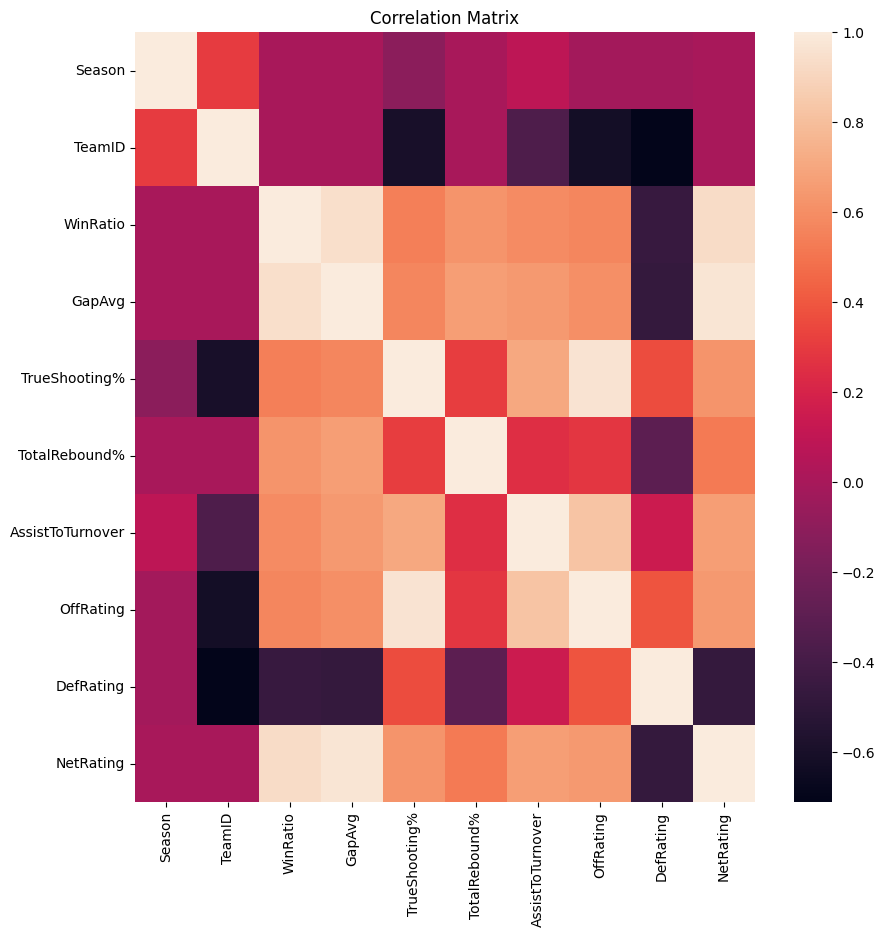

In [151]:
corrs = round(df_features_season.corr(), 2)

import seaborn as sns

plt.figure(figsize=(10,10))
sns.heatmap(corrs)
plt.title('Correlation Matrix')
plt.show()

### Tournament Results 

These are the results from every year we have data for

In [152]:
df_compact_tourney = pd.concat([
    pd.read_csv("march-machine-learning-mania-2023/MNCAATourneyCompactResults.csv"),
    pd.read_csv("march-machine-learning-mania-2023/WNCAATourneyCompactResults.csv")
], ignore_index=True)

df_compact_tourney.drop(['NumOT', 'WLoc'], axis=1, inplace=True)

df_compact_tourney.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore
0,1985,136,1116,63,1234,54
1,1985,136,1120,59,1345,58
2,1985,136,1207,68,1250,43
3,1985,136,1229,58,1425,55
4,1985,136,1242,49,1325,38


## Feature Engineering

### Train Data

In [153]:
df = df_compact_tourney.copy()
df = df[df['Season'] >= 2010].reset_index(drop=True)
# df.head()

#### Tournament Seedings

In [154]:
df = pd.merge(
        df, 
        df_seeds, 
        how='left', 
        left_on=['Season', 'WTeamID'], 
        right_on=['Season', 'TeamID']
).drop('TeamID', axis=1).rename(columns={'Seed': 'SeedW'})

df = pd.merge(
        df, 
        df_seeds, 
        how='left', 
        left_on=['Season', 'LTeamID'], 
        right_on=['Season', 'TeamID']
).drop('TeamID', axis=1).rename(columns={'Seed': 'SeedL'})

Ensure that the seeds only contain numbers

In [155]:
def treat_seed(seed):
        return int(re.sub("[^0-9]", "", seed))

In [156]:
df['SeedW'] = df['SeedW'].apply(treat_seed)
df['SeedL'] = df['SeedL'].apply(treat_seed)
df.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,SeedW,SeedL
0,2010,134,1115,61,1457,44,16,16
1,2010,136,1124,68,1358,59,3,14
2,2010,136,1139,77,1431,59,5,12
3,2010,136,1140,99,1196,92,7,10
4,2010,136,1242,90,1250,74,1,16


#### Add regular season statistics to the dataframe

In [157]:
df = pd.merge(
        df,
        df_features_season,
        how='left',
        left_on=['Season', 'WTeamID'],
        right_on=['Season', 'TeamID']
).rename(columns={
        'WinRatio': 'WinRatioW',
        'GapAvg': 'GapAvgW',
        'TrueShooting%' : 'TrueShootingW',
        'TotalRebound%' : 'TotalReboundW',
        'AssistToTurnover' : 'AssistToTurnoverW',
        'OffRating' : 'OffRatingW',
        'DefRating' : 'DefRatingW',
        'NetRating' : 'NetRatingW',
}).drop(columns='TeamID', axis=1)
df = pd.merge(
        df,
        df_features_season,
        how='left',
        left_on=['Season', 'LTeamID'],
        right_on=['Season', 'TeamID']
).rename(columns={
        'WinRatio': 'WinRatioL',
        'GapAvg': 'GapAvgL',
        'TrueShooting%' : 'TrueShootingL',
        'TotalRebound%' : 'TotalReboundL',
        'AssistToTurnover' : 'AssistToTurnoverL',
        'OffRating' : 'OffRatingL',
        'DefRating' : 'DefRatingL',
        'NetRating' : 'NetRatingL',
}).drop(columns='TeamID', axis=1)
df.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,SeedW,SeedL,WinRatioW,GapAvgW,...,DefRatingW,NetRatingW,WinRatioL,GapAvgL,TrueShootingL,TotalReboundL,AssistToTurnoverL,OffRatingL,DefRatingL,NetRatingL
0,2010,134,1115,61,1457,44,16,16,0.531250,-0.281250,...,84.061596,-4.376779,0.566667,0.633333,0.460374,0.510195,0.885246,78.060019,80.303580,-2.243561
1,2010,136,1124,68,1358,59,3,14,0.774194,10.161290,...,83.038158,13.606508,0.750000,7.571429,0.582176,0.520143,1.462766,97.377723,89.172479,8.205243
2,2010,136,1139,77,1431,59,5,12,0.875000,10.062500,...,82.381295,13.471767,0.812500,11.593750,0.565163,0.505432,1.123515,94.490337,79.186393,15.303944
3,2010,136,1140,99,1196,92,7,10,0.848485,16.939394,...,81.431878,21.672603,0.636364,6.181818,0.533437,0.517607,1.154229,90.298371,84.220135,6.078236
4,2010,136,1242,90,1250,74,1,16,0.941176,17.970588,...,77.935237,21.353314,0.687500,5.093750,0.563441,0.510936,1.163462,94.299656,86.762269,7.537387


#### Change winning team and losing team to TeamA and TeamB

In [158]:
def add_losing_matches(df):
    win_rename = {
        "WTeamID": "TeamIDA", 
        "WScore" : "ScoreA", 
        "LTeamID" : "TeamIDB",
        "LScore": "ScoreB",
        }
    win_rename.update({c : c[:-1] + "A" for c in df.columns if c.endswith('W')})
    win_rename.update({c : c[:-1] + "B" for c in df.columns if c.endswith('L')})

    lose_rename = {
        "WTeamID": "TeamIDB", 
        "WScore" : "ScoreB", 
        "LTeamID" : "TeamIDA",
        "LScore": "ScoreA",
    }
    lose_rename.update({c : c[:-1] + "B" for c in df.columns if c.endswith('W')})
    lose_rename.update({c : c[:-1] + "A" for c in df.columns if c.endswith('L')})

    win_df = df.copy()
    lose_df = df.copy()

    win_df = win_df.rename(columns=win_rename)
    lose_df = lose_df.rename(columns=lose_rename)

    return pd.concat([win_df, lose_df], axis=0, sort=False)
df = add_losing_matches(df)

#### Create columns for statistical difference between teams

In [159]:
cols_to_diff = [
        'Seed', 'WinRatio', 'GapAvg', 'TrueShooting', 'TotalRebound', 'AssistToTurnover', 'OffRating', 'DefRating', 'NetRating'
]
for col in cols_to_diff:
        df[col + 'Diff'] = df[col + 'A'] - df[col + 'B']
df.head()

,Season,DayNum,TeamIDA,ScoreA,TeamIDB,ScoreB,SeedA,SeedB,WinRatioA,GapAvgA,...,NetRatingB,SeedDiff,WinRatioDiff,GapAvgDiff,TrueShootingDiff,TotalReboundDiff,AssistToTurnoverDiff,OffRatingDiff,DefRatingDiff,NetRatingDiff
0,2010,134,1115,61,1457,44,16,16,0.531250,-0.281250,...,-2.243561,0,-0.035417,-0.914583,0.043676,0.037253,-0.145394,1.624798,3.758016,-2.133218
1,2010,136,1124,68,1358,59,3,14,0.774194,10.161290,...,8.205243,-11,0.024194,2.589862,0.004532,0.022184,-0.488112,-0.733057,-6.134321,5.401265
2,2010,136,1139,77,1431,59,5,12,0.875000,10.062500,...,15.303944,-7,0.062500,-1.531250,0.012026,0.024305,-0.090770,1.362726,3.194903,-1.832177
3,2010,136,1140,99,1196,92,7,10,0.848485,16.939394,...,6.078236,-3,0.212121,10.757576,0.066760,0.014215,0.242554,12.806111,-2.788257,15.594367
4,2010,136,1242,90,1250,74,1,16,0.941176,17.970588,...,7.537387,-15,0.253676,12.876838,0.025812,0.034590,0.158534,4.988895,-8.827032,13.815927


### Test Data

#### Prepare the sample submission data for testing

In [160]:
df_test = pd.read_csv("march-machine-learning-mania-2023/SampleSubmission2023.csv")
df_test['Season'] = df_test['ID'].apply(lambda x: int(x.split('_')[0]))
df_test['TeamIDA'] = df_test['ID'].apply(lambda x: int(x.split('_')[1]))
df_test['TeamIDB'] = df_test['ID'].apply(lambda x: int(x.split('_')[2]))
df_test.head()

,ID,Pred,Season,TeamIDA,TeamIDB
0,2023_1101_1102,0.5,2023,1101,1102
1,2023_1101_1103,0.5,2023,1101,1103
2,2023_1101_1104,0.5,2023,1101,1104
3,2023_1101_1105,0.5,2023,1101,1105
4,2023_1101_1106,0.5,2023,1101,1106


#### Add in the current year's seedings

In [161]:
df_test = pd.merge(
    df_test,
    df_seeds,
    how='left',
    left_on=['Season', 'TeamIDA'],
    right_on=['Season', 'TeamID']
).drop('TeamID', axis=1).rename(columns={'Seed': 'SeedA'}).fillna('W00')
df_test = pd.merge(
    df_test, 
    df_seeds, 
    how='left', 
    left_on=['Season', 'TeamIDB'], 
    right_on=['Season', 'TeamID']
).drop('TeamID', axis=1).rename(columns={'Seed': 'SeedB'}).fillna('W00')
df_test['SeedA'] = df_test['SeedA'].apply(treat_seed)
df_test['SeedB'] = df_test['SeedB'].apply(treat_seed)
df_test.head()

,ID,Pred,Season,TeamIDA,TeamIDB,SeedA,SeedB
0,2023_1101_1102,0.5,2023,1101,1102,0,0
1,2023_1101_1103,0.5,2023,1101,1103,0,0
2,2023_1101_1104,0.5,2023,1101,1104,0,1
3,2023_1101_1105,0.5,2023,1101,1105,0,0
4,2023_1101_1106,0.5,2023,1101,1106,0,0


#### Add the 2023 season statistics to the testing data

In [162]:
df_test = pd.merge(
        df_test,
        df_features_season,
        how='left',
        left_on=['Season', 'TeamIDA'],
        right_on=['Season', 'TeamID']
).rename(columns={
        'WinRatio': 'WinRatioA',
        'GapAvg': 'GapAvgA',
        'TrueShooting%' : 'TrueShootingA',
        'TotalRebound%' : 'TotalReboundA',
        'AssistToTurnover' : 'AssistToTurnoverA',
        'OffRating' : 'OffRatingA',
        'DefRating' : 'DefRatingA',
        'NetRating' : 'NetRatingA',
}).drop(columns='TeamID', axis=1)

df_test = pd.merge(
        df_test,
        df_features_season,
        how='left',
        left_on=['Season', 'TeamIDB'],
        right_on=['Season', 'TeamID']
).rename(columns={
        'WinRatio': 'WinRatioB',
        'GapAvg': 'GapAvgB',
        'TrueShooting%' : 'TrueShootingB',
        'TotalRebound%' : 'TotalReboundB',
        'AssistToTurnover' : 'AssistToTurnoverB',
        'OffRating' : 'OffRatingB',
        'DefRating' : 'DefRatingB',
        'NetRating' : 'NetRatingB',
}).drop(columns='TeamID', axis=1)

In [163]:
def average_if_na(df, features):
    for feature in features:
        df[feature] = df[feature].fillna(df[feature].mean())

In [164]:
not_feature = ['ID', 'Pred', 'Season', 'TeamIDA', 'TeamIDB']
features = [col for col in df_test.columns.values if col not in not_feature]
average_if_na(df_test, features)


#### Create the difference columns

In [165]:
for col in cols_to_diff:
        df_test[col + 'Diff'] = df_test[col + 'A'] - df_test[col + 'B']

### Create the target columns in the testing dataframe

In [166]:
df['ScoreDiff'] = df['ScoreA'] - df["ScoreB"]
df['WinA'] = (df['ScoreDiff'] > 0).astype(int)

## Feature selection

In [167]:
def variants(features):
    res = []
    for feature in features:
        res.append(feature + "A")
        res.append(feature + "B")
        res.append(feature + "Diff")
    return res

In [168]:
not_feature = ['Season', 'DayNum', 'TeamIDA', 'ScoreA', 'TeamIDB', 'ScoreB', 'ScoreDiff', 'WinA']
actual_features = ['WinRatio', 'GapAvg', 'TrueShooting', 'TotalRebound', 'AssistToTurnover', 'OffRating', 'DefRating', 'NetRating']
also_not = variants([f for f in actual_features if f not in keep])
features = [col for col in df.columns.values if col not in not_feature + also_not]
features

['SeedA',
 'SeedB',
 'WinRatioA',
 'GapAvgA',
 'TrueShootingA',
 'TotalReboundA',
 'AssistToTurnoverA',
 'OffRatingA',
 'DefRatingA',
 'NetRatingA',
 'WinRatioB',
 'GapAvgB',
 'TrueShootingB',
 'TotalReboundB',
 'AssistToTurnoverB',
 'OffRatingB',
 'DefRatingB',
 'NetRatingB',
 'SeedDiff',
 'WinRatioDiff',
 'GapAvgDiff',
 'TrueShootingDiff',
 'TotalReboundDiff',
 'AssistToTurnoverDiff',
 'OffRatingDiff',
 'DefRatingDiff',
 'NetRatingDiff']

## Modelling

In [169]:
def rescale(features, df_train, df_val, df_test=None):
    min_ = df_train[features].min()
    max_ = df_train[features].max()
    
    df_train[features] = (df_train[features] - min_) / (max_ - min_)
    df_val[features] = (df_val[features] - min_) / (max_ - min_)
    
    if df_test is not None:
            df_test[features] = (df_test[features] - min_) / (max_ - min_)
            
    return df_train, df_val, df_test

### Cross Validation

We used K-Fold cross validation to reduce overfitting. The data is separated by season

In [170]:
def kfold(df, df_test_=None, features=features, verbose=True, mode="ridge", c=1, penalty='l2'):
    seasons = df['Season'].unique()
    cvs = []
    roc_aucs = []
    pred_tests = []
    target = "ScoreDiff" if mode == "reg" else "WinA"
    
    for season in seasons[1:]:
        if verbose:
            print(f'\nCross-validated in season {season}')
        
        df_train = df[df['Season'] < season].reset_index(drop=True).copy()
        df_val = df[df['Season'] == season].reset_index(drop=True).copy()
        df_test = df_test_.copy()
        
        df_train, df_val, df_test = rescale(features, df_train, df_val, df_test)
        
        if mode == "ridge":
            model = Ridge(alpha=1/c)
        elif mode == "nb":
            model = GaussianNB()
        elif mode == "logreg":
            model = LogisticRegression(penalty=penalty, C=c, max_iter=400)

        model.fit(df_train[features], df_train[target])
        
        if mode == "ridge":
                pred = model.predict(df_val[features])
        else:
                pred = model.predict_proba(df_val[features])[:, 1]
        
        if df_test is not None:
            if mode == "ridge":
                pred_test = model.predict(df_test[features])
                pred_test = (pred_test - pred_test.min()) / (pred_test.max() - pred_test.min())
            else:
                pred_test = model.predict_proba(df_test[features])[:, 1]
                    
            pred_tests.append(pred_test)
        
        pred = (pred - pred.min()) / (pred.max() - pred.min())
        pred = np.clip(pred, 0, 1)

        score = ((df_val['WinA'].values - pred) ** 2).mean()
        cvs.append(score)

        roc_auc = roc_auc_score(df_val["WinA"], pred)
        roc_aucs.append(roc_auc)

        if verbose:
            print(f'\t -> CV Score {score:.4f}')
            print(f'\t -> ROC AUC Score: {roc_auc:.4f}\n')
            
    mean_cv = np.mean(cvs)
    mean_roc_auc = np.mean(roc_aucs)
    print(f'Local CV is {mean_cv:.4f}')
    print(f'Local ROC AUC is {mean_roc_auc:.4f}')
    # Calculate accuracy
    return pred_tests, mean_cv, mean_roc_auc

## Results

### Hyperparameter Tuning

In [171]:
ridge_cvs = []
ridge_roc_aucs = []
for C in range(25):
        print(f'\nFor C = {C+1}')
        pred_tests, mean_cv, mean_roc_auc = kfold(df, df_test, verbose=False, mode="ridge", c=C+1)
        ridge_cvs.append(mean_cv)
        ridge_roc_aucs.append(mean_roc_auc)


For C = 1


Local CV is 0.1860
Local ROC AUC is 0.8127

For C = 2
Local CV is 0.1862
Local ROC AUC is 0.8129

For C = 3
Local CV is 0.1863
Local ROC AUC is 0.8127

For C = 4
Local CV is 0.1863
Local ROC AUC is 0.8129

For C = 5
Local CV is 0.1863
Local ROC AUC is 0.8129

For C = 6
Local CV is 0.1864
Local ROC AUC is 0.8128

For C = 7
Local CV is 0.1864
Local ROC AUC is 0.8127

For C = 8
Local CV is 0.1864
Local ROC AUC is 0.8127

For C = 9
Local CV is 0.1864
Local ROC AUC is 0.8127

For C = 10
Local CV is 0.1864
Local ROC AUC is 0.8126

For C = 11
Local CV is 0.1864
Local ROC AUC is 0.8125

For C = 12
Local CV is 0.1864
Local ROC AUC is 0.8126

For C = 13
Local CV is 0.1864
Local ROC AUC is 0.8125

For C = 14
Local CV is 0.1864
Local ROC AUC is 0.8125

For C = 15
Local CV is 0.1864
Local ROC AUC is 0.8126

For C = 16
Local CV is 0.1864
Local ROC AUC is 0.8126

For C = 17
Local CV is 0.1864
Local ROC AUC is 0.8125

For C = 18
Local CV is 0.1864
Local ROC AUC is 0.8126

For C = 19
Local CV is 0.1864

In [172]:
log_cvs = []
log_roc_aucs = []
for C in range(25):
        print(f'\nFor C = {C+1}')
        pred_tests, mean_cv, mean_roc_auc = kfold(df, df_test, verbose=False, mode="logreg", c=C+1)
        log_cvs.append(mean_cv)
        log_roc_aucs.append(mean_roc_auc)


For C = 1
Local CV is 0.1778
Local ROC AUC is 0.8118

For C = 2
Local CV is 0.1780
Local ROC AUC is 0.8125

For C = 3
Local CV is 0.1781
Local ROC AUC is 0.8127

For C = 4
Local CV is 0.1782
Local ROC AUC is 0.8124

For C = 5
Local CV is 0.1782
Local ROC AUC is 0.8125

For C = 6
Local CV is 0.1783
Local ROC AUC is 0.8126

For C = 7
Local CV is 0.1784
Local ROC AUC is 0.8124

For C = 8
Local CV is 0.1784
Local ROC AUC is 0.8124

For C = 9
Local CV is 0.1784
Local ROC AUC is 0.8125

For C = 10
Local CV is 0.1785
Local ROC AUC is 0.8125

For C = 11
Local CV is 0.1785
Local ROC AUC is 0.8126

For C = 12
Local CV is 0.1785
Local ROC AUC is 0.8126

For C = 13
Local CV is 0.1786
Local ROC AUC is 0.8125

For C = 14
Local CV is 0.1786
Local ROC AUC is 0.8123

For C = 15
Local CV is 0.1786
Local ROC AUC is 0.8123

For C = 16
Local CV is 0.1786
Local ROC AUC is 0.8124

For C = 17
Local CV is 0.1786
Local ROC AUC is 0.8123

For C = 18
Local CV is 0.1787
Local ROC AUC is 0.8123

For C = 19
Local C

In [173]:
cs = list(range(1, 26))

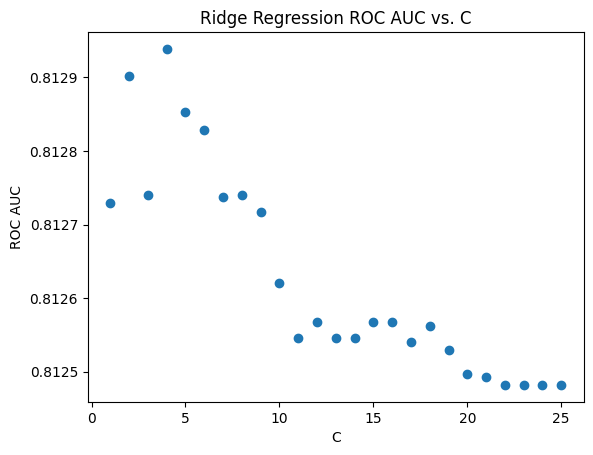

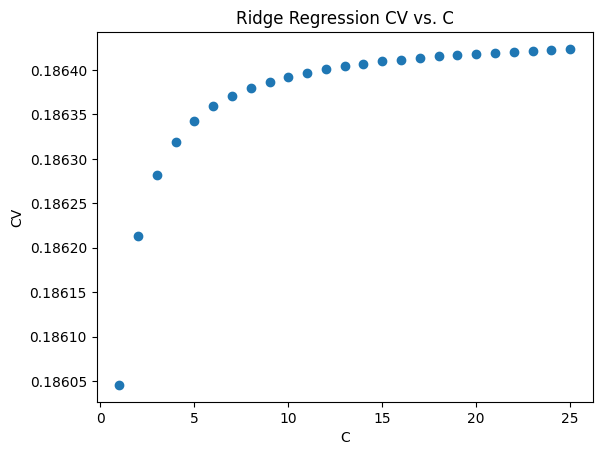

In [174]:
plt.scatter(cs, ridge_roc_aucs)
plt.title("Ridge Regression ROC AUC vs. C")
plt.xlabel("C")
plt.ylabel("ROC AUC")
plt.show()
plt.scatter(cs, ridge_cvs)
plt.title("Ridge Regression CV vs. C")
plt.xlabel("C")
plt.ylabel("CV")
plt.show()

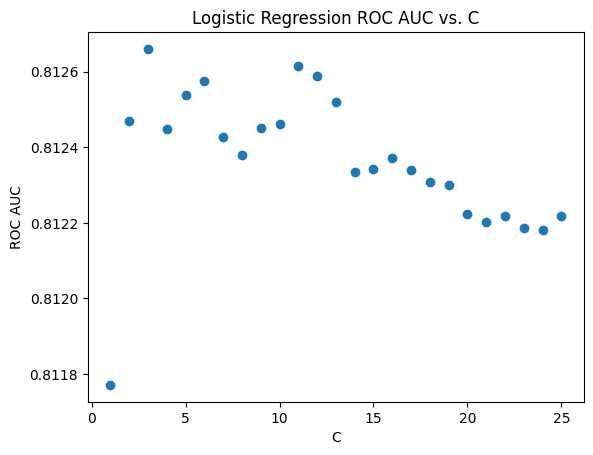

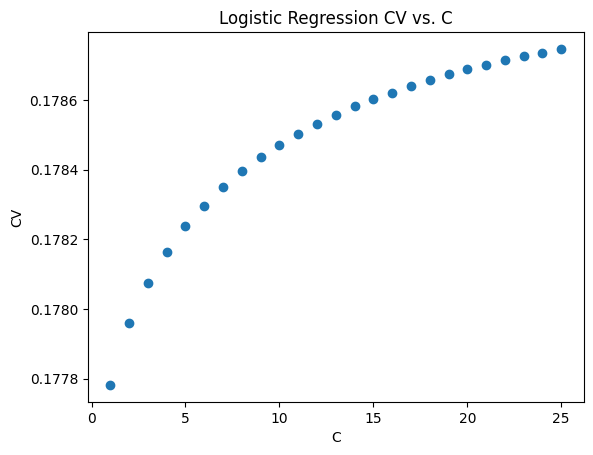

In [175]:
plt.scatter(cs, log_roc_aucs)
plt.title("Logistic Regression ROC AUC vs. C")
plt.xlabel("C")
plt.ylabel("ROC AUC")
plt.show()
plt.scatter(cs, log_cvs)
plt.title("Logistic Regression CV vs. C")
plt.xlabel("C")
plt.ylabel("CV")
plt.show()

### Final Results

#### Baseline

In [176]:
from sklearn.dummy import DummyClassifier

baseline = DummyClassifier(strategy="most_frequent")

df_baseline = df.copy()

df_baseline = rescale(features, df_baseline, df.copy(), df.copy())

baseline_accuracy = sum(cross_val_score(baseline, df[features], df['WinA'], scoring='accuracy')) / 5
baseline_score = sum(cross_val_score(baseline, df[features], df['WinA'], scoring='roc_auc')) / 5

print("Baseline accuracy:", baseline_accuracy)
print("Baseline score (roc_auc):", baseline_score)

Baseline accuracy: 0.5
Baseline score (roc_auc): 0.5


#### Gaussian Naive Bayes

In [177]:
nb_pred_tests, nb_mean_cv, nb_mean_roc_auc = kfold(df, df_test, verbose=True, mode="nb")


Cross-validated in season 2011
	 -> CV Score 0.3065
	 -> ROC AUC Score: 0.7586


Cross-validated in season 2012
	 -> CV Score 0.2585
	 -> ROC AUC Score: 0.7854


Cross-validated in season 2013
	 -> CV Score 0.2911
	 -> ROC AUC Score: 0.7485


Cross-validated in season 2014
	 -> CV Score 0.2641
	 -> ROC AUC Score: 0.7830


Cross-validated in season 2015
	 -> CV Score 0.2216
	 -> ROC AUC Score: 0.8264


Cross-validated in season 2016
	 -> CV Score 0.2416
	 -> ROC AUC Score: 0.7657


Cross-validated in season 2017
	 -> CV Score 0.2579
	 -> ROC AUC Score: 0.7759


Cross-validated in season 2018
	 -> CV Score 0.2976
	 -> ROC AUC Score: 0.7538


Cross-validated in season 2019
	 -> CV Score 0.2383
	 -> ROC AUC Score: 0.8154


Cross-validated in season 2021
	 -> CV Score 0.3004
	 -> ROC AUC Score: 0.7478


Cross-validated in season 2022
	 -> CV Score 0.2540
	 -> ROC AUC Score: 0.7677

Local CV is 0.2665
Local ROC AUC is 0.7753


#### Logistic Regression

In [178]:
log_pred_tests, log_mean_cv, log_mean_roc_auc = kfold(df, df_test, verbose=True, mode="logreg", c=1)


Cross-validated in season 2011
	 -> CV Score 0.1974
	 -> ROC AUC Score: 0.7725


Cross-validated in season 2012
	 -> CV Score 0.1657
	 -> ROC AUC Score: 0.8327


Cross-validated in season 2013
	 -> CV Score 0.1903
	 -> ROC AUC Score: 0.7881


Cross-validated in season 2014
	 -> CV Score 0.1802
	 -> ROC AUC Score: 0.8068


Cross-validated in season 2015
	 -> CV Score 0.1457
	 -> ROC AUC Score: 0.8779


Cross-validated in season 2016
	 -> CV Score 0.1800
	 -> ROC AUC Score: 0.8063


Cross-validated in season 2017
	 -> CV Score 0.1657
	 -> ROC AUC Score: 0.8380


Cross-validated in season 2018
	 -> CV Score 0.1907
	 -> ROC AUC Score: 0.7884


Cross-validated in season 2019
	 -> CV Score 0.1529
	 -> ROC AUC Score: 0.8592


Cross-validated in season 2021
	 -> CV Score 0.1903
	 -> ROC AUC Score: 0.7864


Cross-validated in season 2022
	 -> CV Score 0.1968
	 -> ROC AUC Score: 0.7731

Local CV is 0.1778
Local ROC AUC is 0.8118


#### Ridge Regression

In [179]:
ridge_pred_tests, ridge_mean_cv, ridge_mean_roc_auc = kfold(df, df_test, verbose=True)


Cross-validated in season 2011
	 -> CV Score 0.1957
	 -> ROC AUC Score: 0.7657


Cross-validated in season 2012
	 -> CV Score 0.1810
	 -> ROC AUC Score: 0.8402


Cross-validated in season 2013
	 -> CV Score 0.1906
	 -> ROC AUC Score: 0.7947


Cross-validated in season 2014
	 -> CV Score 0.1893
	 -> ROC AUC Score: 0.8053


Cross-validated in season 2015
	 -> CV Score 0.1758
	 -> ROC AUC Score: 0.8786


Cross-validated in season 2016
	 -> CV Score 0.1899
	 -> ROC AUC Score: 0.8089


Cross-validated in season 2017
	 -> CV Score 0.1756
	 -> ROC AUC Score: 0.8448


Cross-validated in season 2018
	 -> CV Score 0.1916
	 -> ROC AUC Score: 0.7853


Cross-validated in season 2019
	 -> CV Score 0.1721
	 -> ROC AUC Score: 0.8583


Cross-validated in season 2021
	 -> CV Score 0.1882
	 -> ROC AUC Score: 0.7922


Cross-validated in season 2022
	 -> CV Score 0.1967
	 -> ROC AUC Score: 0.7660

Local CV is 0.1860
Local ROC AUC is 0.8127
